## Introduction

The Capital Asset Pricing Model aims to establish a linear relationship between systematic risk and expected return. Refer to the equation below : (ER_m - R_f) => represents the market risk premium, an amount that accounts for the additional risk taken by investors when they choose to invest in a risky market. Similarly, (ER_i- R_f) refers to the equity risk premium. Beta is a measure of the volatility of a security compared to the market as a whole's (for e.g. S&P 500) systematic risk. We aim to estimate the 'Beta' term here using simple linear regression. R_f, the intercept, is already pre-assumed to be equal to 10-year treasury bill rate (return (interest rate) on government bonds that mature in 10 years)


\
                    $$ ER_i = R_f + \beta_i (ER_m - R_f) $$ 


\begin{align*}
ER_i &= \text{expected return of investment} \\
R_f &= \text{risk-free rate} \\
\beta_i &= \text{beta of the investment} \\
(ER_m - R_f) &= \text{market risk premium}
\end{align*}



We will implement linear regression using PyTorch so that we can optimise the gradient descent process.

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
rf_rate = 6.31*0.01/252 #since rf rate is annualized; has to be scaled down
start_date = '2023-08-01'
end_date = '2025-08-01'
stock = yf.download('AAPL', start=start_date, end=end_date,auto_adjust=False)['Adj Close']
market = yf.download('^GSPC', start=start_date, end=end_date,auto_adjust=False)['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
stock_returns = stock.pct_change().dropna() #acts as Y variable
market_returns = market.pct_change().dropna()


In [4]:
market_risk_premium = (market_returns - rf_rate) #acts as X variable

In [5]:
X = market_risk_premium.to_numpy()
Y = stock_returns.to_numpy()

(501, 1)
(501, 1)


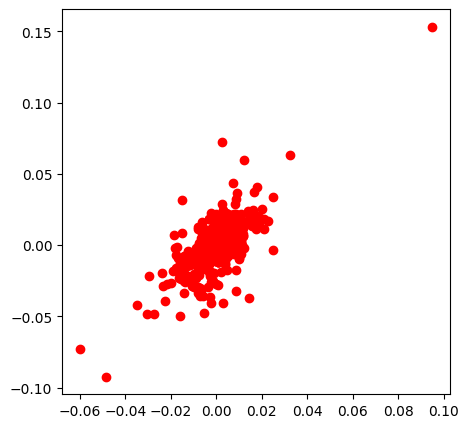

In [6]:
print(X.shape)#m,1
print(Y.shape)#m,1
plt.figure(figsize=(5, 5))
plt.plot(X,Y,'or')

From the appearance of the graph, we understand that the slope must be positive, so we can initialise 'w' with a positive value. For initialisations, the easiest way would be to simply use the closed form solution for linear regression (direct formula application) and start from there. We can also initialise 'w' with random values but this brings about a dependence on initialised values (faster convergence if initialised closer to optimal value and slower convergence if initialised farther). To solve this issue, I use the Adam optimizer.

In [26]:
#Cost Function and Gradient Descent

def cost(x, y, w, b):
    # Flatten y to (m,)
    y = y.flatten()
    f_wb = np.dot(x, w) + b         # shape: (m,)
    error = f_wb - y                # shape match ensured
    cost = (1 / (2 * len(y))) * np.sum(error ** 2)
    return cost

'''
def gd(x,y,w,b,learning_rate):
    
    y : (m,)
    x : (m,n)
    w : (n,)
    b : scalar

    m=y.shape[0]
    f_wb=np.dot(x,w)+b
    dJ_dw=1/m*np.sum((f_wb-y)*x)
    w-=learning_rate*dJ_dw
    return w
'''

'\ndef gd(x,y,w,b,learning_rate):\n\n    y : (m,)\n    x : (m,n)\n    w : (n,)\n    b : scalar\n\n    m=y.shape[0]\n    f_wb=np.dot(x,w)+b\n    dJ_dw=1/m*np.sum((f_wb-y)*x)\n    w-=learning_rate*dJ_dw\n    return w\n'

In [8]:
#Model
'''
def model(x,y,learning_rate,iterations,b,w_init):
    costlist=[]
    wlist=[]
    w=w_init
    for i in range(iterations):
        cost_=cost(x,y,w,b)
        costlist.append(cost_)
        wlist.append(w)
        w=gd(x,y,w,b,learning_rate)
        if i%(iterations/10)==0:
            print(f"Cost after {i} iterations is: {cost_}")
            print(w)

    parameters={"w":w,"b":b}
    return parameters,costlist
'''

'\ndef model(x,y,learning_rate,iterations,b,w_init):\n    costlist=[]\n    wlist=[]\n    w=w_init\n    for i in range(iterations):\n        cost_=cost(x,y,w,b)\n        costlist.append(cost_)\n        wlist.append(w)\n        w=gd(x,y,w,b,learning_rate)\n        if i%(iterations/10)==0:\n            print(f"Cost after {i} iterations is: {cost_}")\n            print(w)\n\n    parameters={"w":w,"b":b}\n    return parameters,costlist\n'

In [19]:
X_t = torch.tensor(X, dtype=torch.float32)
Y_t = torch.tensor(Y, dtype=torch.float32)
iterations=5000
w = torch.randn(1, requires_grad=True)
b = torch.tensor([rf_rate], requires_grad=False)  #to make sure the rf rate is a constant intercept

optimizer = torch.optim.Adam([w], lr=0.01)
cost_list=[]
for i in range(iterations):
    optimizer.zero_grad() #to clear the prev gradients
    pred = X_t * w + b
    loss = ((pred - Y_t) ** 2).mean()
    loss.backward() #gradient of loss/backprop
    optimizer.step() #apply update
    cost_list.append(loss.item())
    if i % 100 == 0:
        
        print(f"Iter {i}: loss = {loss.item()}, w = {w.item()}, b = {b.item()}")


Iter 0: loss = 0.0003350330516695976, w = 2.5203776359558105, b = 0.00025039681349880993
Iter 100: loss = 0.00017766068049240857, w = 1.6828912496566772, b = 0.00025039681349880993
Iter 200: loss = 0.00015412815264426172, w = 1.3029652833938599, b = 0.00025039681349880993
Iter 300: loss = 0.00015298077778425068, w = 1.2106382846832275, b = 0.00025039681349880993
Iter 400: loss = 0.0001529647270217538, w = 1.1991398334503174, b = 0.00025039681349880993
Iter 500: loss = 0.0001529646833660081, w = 1.1984355449676514, b = 0.00025039681349880993
Iter 600: loss = 0.0001529646833660081, w = 1.198418378829956, b = 0.00025039681349880993
Iter 700: loss = 0.0001529646833660081, w = 1.198418378829956, b = 0.00025039681349880993
Iter 800: loss = 0.0001529646833660081, w = 1.198418378829956, b = 0.00025039681349880993
Iter 900: loss = 0.0001529646833660081, w = 1.198418378829956, b = 0.00025039681349880993
Iter 1000: loss = 0.0001529646833660081, w = 1.198418378829956, b = 0.00025039681349880993
It

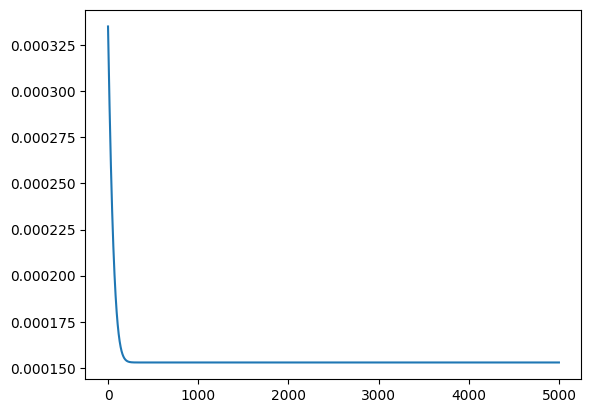

In [20]:
t = np.arange(0, iterations)
plt.plot(t, cost_list)
plt.show()

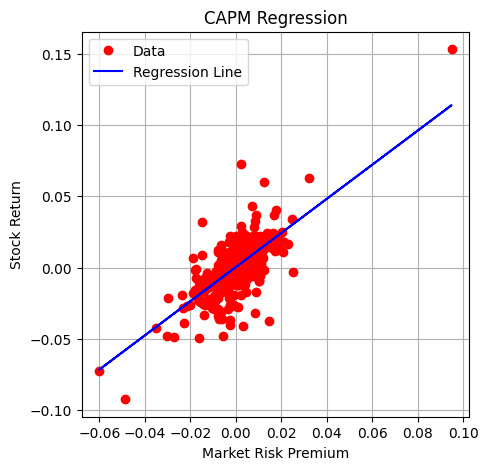

In [21]:
# Predicted Y values
Y_pred = (X_t * w + b).detach().numpy()
# Plot
plt.figure(figsize=(5, 5))
plt.plot(X, Y, 'or', label='Data')              # Red dots
plt.plot(X, Y_pred, '-b', label='Regression Line')  # Blue line
plt.xlabel("Market Risk Premium")
plt.ylabel("Stock Return")
plt.title("CAPM Regression")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
print(cost(X,Y,w.detach().numpy(),b.detach().numpy()))

7.648234221878597e-05


In [28]:
y_mean = torch.mean(Y_t)
ss_tot = torch.sum((Y_t - y_mean) ** 2)
ss_res = torch.sum((Y_t - pred) ** 2)
r_squared = 1 - ss_res / ss_tot
print("R²:", r_squared.item())


R²: 0.49071770906448364


In [25]:
print(f"Final Results: Beta = {w} when Risk Free Rate is taken as {b.item():.10f}")

Final Results: Beta = tensor([1.1984], requires_grad=True) when Risk Free Rate is taken as 0.0002503968
